In [1]:
import torch
import os

import numpy as np

from sklearn.metrics import roc_curve, f1_score

# [!!OLD DO NOT RUN!!] Gathering modeloutputs

In [2]:
modelOutputs = {}

for path in os.listdir("eval_results"):
    if ".pth" not in path:
        continue

    modelOutputs[path] = torch.load("eval_results/" + path, weights_only=False) 

# [NEW] Gathering Modeloutputs

In [ ]:
modelOutputs = {}

# if you look at the winner_data collect the logits 
# and put them in the big modelOutputs dict, the reset of this noteobok should work

In [3]:
modelOutputs.keys()

dict_keys(['convnextv2_nano.fcmae_ft_in22k_in1k_384.redo_results.pth', 'convnextv2_nano.lessdrop_results.pth', 'convnextv2_nano_50e_results.pth', 'convnextv2_tiny.fcmae_ft_in22k_in1k.lessdrop_results.pth', 'convnextv2_tiny.fcmae_ft_in22k_in1k.nodrop_results.pth', 'convnextv2_tiny.fcmae_ft_in22k_in1k_results.pth', 'fastvit_ma36.apple_dist_in1k.nodrop_results.pth', 'fastvit_ma36.apple_dist_in1k_results.pth', 'fastvit_ma36_results.pth', 'fastvit_t8.apple_dist_in1k.nodrop_results.pth', 'fastvit_t8.apple_dist_in1k_results.pth', 'fastvit_t8_results.pth', 'mobilenetv4_conv_aa_large.e230_r448_in12k_ft_in1k.redo.nodrop_results.pth', 'mobilenetv4_conv_aa_large.e230_r448_in12k_ft_in1k.redo_results.pth', 'mobilenetv4_conv_aa_large.e230_r448_in12k_ft_in1k_results.pth', 'mobilenetv4_conv_medium.e500_r256_in1k_results.pth', 'repvit_m2_3.dist_450e_in1k.lessdrop_results.pth', 'repvit_m2_3.dist_450e_in1k_results.pth', 'repvit_m3.dist_in1k.lessdrop_results.pth', 'repvit_m3.dist_in1k_results.pth', 'resnet

In [4]:
def max_f1_score(y_true, probs): #fixed to be specific to each fold; takes GT and post-sigmoid confidences as probs
    max_f1 = 0
    best_thresh = 0

    for thresh in np.arange(0.01, 1.01, 0.01):
        y_pred = (probs.flatten() > thresh).astype(int)

        local_f1 = f1_score(y_true, y_pred)
        if local_f1 > max_f1:
            max_f1 = local_f1
            best_thresh = thresh

    return max_f1, best_thresh #maximum score, threshold

In [5]:
def sort_dict_by_values(d, reverse=True):
    """Return a dictionary sorted by its values."""
    return dict(sorted(d.items(), key=lambda item: item[1], reverse=reverse))

# Evaluate all base models, ensuring per-fold F1 scores are considered

In [16]:
modelGroupReps = [ #TODO: replace with no drop versions
    'fastvit_ma36.apple_dist_in1k_results.pth', 
    'mobilenetv4_conv_medium.e500_r256_in1k_results.pth', 
    'repvit_m3.dist_in1k.lessdrop_results.pth', 
    'resnetv2_18_results.pth',
    'tf_efficientnetv2_s.in21k_results.pth',
    'convnextv2_nano.lessdrop_results.pth'
]
modelGroupRepCommonName = [
    'FastViT ma36',    
    'MobileNet V4 medium',
    'RepViT m3',
    'ResNet V2',
    'EfficientNet V2',
    'ConvNeXt V2 Nano',
    'Ensemble' #for later use
]

modelDataAllFolds = {} #collect data for all folds
modelPredAllFolds = {}

for fold_i in range(5):
    foldData = {} #collect data for each fold
    #-----------------------CALCULATE PERFORMANCE OF ALL MODELS BASED ON F1 SCORE-----------------------
    for model_path in modelOutputs:
        modelData = {} #collect all data for a specific model of a specific fold
        y_true = modelOutputs[model_path][fold_i][0] #should be consistent with every loop
        probs = modelOutputs[model_path][fold_i][1]
        if model_path in modelGroupReps:
            commonName = modelGroupRepCommonName[modelGroupReps.index(model_path)]
            if commonName in modelPredAllFolds.keys():
                modelPredAllFolds[commonName][fold_i] = probs
            else:
                modelPredAllFolds[commonName] = {}
                modelPredAllFolds[commonName][fold_i] = probs
        
        # f1, threshold = max_f1_score(GTs, probs)
        # modelData['f1-score'] = f1 #set f1_scores of model to threshold

        #setting global threshold for consistency and avoid bias
        y_pred = (probs.flatten() > 0.5).astype(int)
        
        modelData['f1-score'] = f1_score(y_true, y_pred)
        modelData['acc'] = np.sum(y_pred == y_true.flatten())/len(y_true) #set f1_scores of model to threshold

        #------------BINARIZE BASED ON THRESH; [-1,1]------------
        modelData['preds'] = y_pred
        modelData['preds'] *= 2
        modelData['preds'] -= 1
        #------------BINARIZE COMPLETE------------
        foldData[model_path] = modelData

    #-----------------------BEST MODEL CALCULATIONS COMPLETE-----------------------
    modelDataAllFolds[f'fold {fold_i+1}'] = foldData

# Build metadata table to clearly designate mean of means with SD in addition to pooled means

In [17]:
allModelMetaData = {}

for modelName in modelDataAllFolds['fold 1'].keys():
    modelMetaData = {}
    modelMetaData['f1s'] = []
    modelMetaData['accs'] = []
    for fold in modelDataAllFolds.keys():
        modelMetaData['f1s'].append(modelDataAllFolds[fold][modelName]['f1-score'])
        modelMetaData['accs'].append(modelDataAllFolds[fold][modelName]['acc'])
        modelMetaData[f'{fold} preds'] = modelDataAllFolds[fold][modelName]['preds']
    modelMetaData['f1s'] = np.array(modelMetaData['f1s'])
    modelMetaData['accs'] = np.array(modelMetaData['accs'])
    allModelMetaData[modelName] = modelMetaData

# Determine best models for ensemble

In [18]:
# model_common_names = [
#     'convNextV2 nano (imageNet 22k+1k)',
#     'convNextV2 nano (imageNet 22k+1k)',
#     '',
#     '',
#     '',
#     '',
#     '',
#     '',
#     '',
#     '',
#     '',
#     '',
#     '',
#     '',
#     ''
# ]
modelNameStrLimit = 70
for modelName in modelDataAllFolds['fold 1'].keys():
    print(f"{modelName[:modelNameStrLimit]:<{modelNameStrLimit}}| avg f1: {allModelMetaData[modelName]['f1s'].mean():.5f}| avg acc: {allModelMetaData[modelName]['accs'].mean():.5f}")

convnextv2_nano.fcmae_ft_in22k_in1k_384.redo_results.pth              | avg f1: 0.75776| avg acc: 0.76381
convnextv2_nano.lessdrop_results.pth                                  | avg f1: 0.76058| avg acc: 0.76902
convnextv2_nano_50e_results.pth                                       | avg f1: 0.74597| avg acc: 0.75811
convnextv2_tiny.fcmae_ft_in22k_in1k.lessdrop_results.pth              | avg f1: 0.72413| avg acc: 0.73911
convnextv2_tiny.fcmae_ft_in22k_in1k.nodrop_results.pth                | avg f1: 0.70769| avg acc: 0.74173
convnextv2_tiny.fcmae_ft_in22k_in1k_results.pth                       | avg f1: 0.72463| avg acc: 0.73236
fastvit_ma36.apple_dist_in1k.nodrop_results.pth                       | avg f1: 0.92383| avg acc: 0.92494
fastvit_ma36.apple_dist_in1k_results.pth                              | avg f1: 0.92362| avg acc: 0.92628
fastvit_ma36_results.pth                                              | avg f1: 0.91507| avg acc: 0.90987
fastvit_t8.apple_dist_in1k.nodrop_results.pth 

# Calculate metrics for ensemble and put into a seperate metadata struct
## Additionallly, see if any individual model gets samples correct that the ensemble does not (error analysis)

In [37]:
ensembleSubModelNames = [ #TODO: replace with no drop versions
    'fastvit_ma36.apple_dist_in1k_results.pth', 
    'mobilenetv4_conv_medium.e500_r256_in1k_results.pth', 
    'repvit_m3.dist_in1k.lessdrop_results.pth', 
    'resnetv2_18_results.pth',
    'tf_efficientnetv2_s.in21k_results.pth'
]

ensembleModelMetaData = {}
ensembleModelMetaData['f1s'] = []
ensembleModelMetaData['accs'] = []
ensErrorAnalysis = []
ensAdvantageAnalysis = np.zeros(len(modelGroupReps)) #not just the models in the ensemble
    
for fold_i, fold in enumerate(modelDataAllFolds.keys()):
    ensembleModelMetaData[f'{fold} preds'] = []
    #-------------------------BUILDING ENSEMBLE DATA-------------------------
    for modelName in ensembleSubModelNames: #only add specific models
        #starts as list, so this operation appends; then it is converted to numpy, so it will do elemental add
        if len(ensembleModelMetaData[f'{fold} preds']) == 0:
            ensembleModelMetaData[f'{fold} preds'] = modelDataAllFolds[fold][modelName]['preds']
            ensembleModelMetaData[f'{fold} preds'] = np.array(ensembleModelMetaData[f'{fold} preds'])
        else:
            ensembleModelMetaData[f'{fold} preds'] = ensembleModelMetaData[f'{fold} preds'] + modelDataAllFolds[fold][modelName]['preds']

    y_true = modelOutputs[modelName][fold_i][0]
    y_pred = np.array(ensembleModelMetaData[f'{fold} preds'].flatten() > 0).astype(int)

    #-----------ERROR ANALYSIS; SEE IF ANY INDIVIDUAL MODELS GET THE RIGHT ANSWER WHEN ENSEMBLE DOES NOT AND VICE VERSA; include unused convNext-----------
    ensembleCorrectness = (y_pred == y_true.flatten())
    foldEnsErrorAnalysis = [[] for i in range(len(y_true))] #check for any samples where single models get correct, but ensemble does not
    for modelIdx, modelName in enumerate(modelGroupReps): #only add model group reps
        modelPreds = modelDataAllFolds[fold][modelName]['preds']
        modelPreds = np.array(modelPreds>0)
        modelCorrectness = np.array(modelPreds == y_true.flatten())

        #calculate advantages singles models have made over ensemble
        ensErrOverModel = np.logical_and(modelCorrectness, modelCorrectness != ensembleCorrectness)
        for i in range(len(y_true)):
         if ensErrOverModel[i]:
            foldEnsErrorAnalysis[i].append(modelIdx)

        #calculate advantages of ensemble over singles models
        modelErrOverEns = np.logical_and(ensembleCorrectness, ensembleCorrectness != modelCorrectness)

        for i in range(len(y_true)):
         if modelErrOverEns[i]:
            ensAdvantageAnalysis[modelIdx] = ensAdvantageAnalysis[modelIdx] + 1

    y_true = modelOutputs[modelName][fold_i][0].flatten().astype(int)
    y_pred = (ensembleModelMetaData[f'{fold} preds'].flatten() > 0).astype(int)
    
    ensembleModelMetaData['f1s'].append(f1_score(y_true, y_pred))
    ensembleModelMetaData['accs'].append(np.sum(y_pred == y_true.flatten())/len(y_true))

    ensErrorAnalysis.append(foldEnsErrorAnalysis)
ensembleModelMetaData['f1s'] = np.array(ensembleModelMetaData['f1s'])
ensembleModelMetaData['accs'] = np.array(ensembleModelMetaData['accs'])
# modelDataAllFolds
# #-----------------------CALCULATE BEST ENSEMBLE MODEL BASED ON SELECTING-----------------------


In [40]:
print(f"Ensemble | f1: {ensembleModelMetaData['f1s'].mean():.5f} | acc: {ensembleModelMetaData['accs'].mean():.5f}\n")
numEnsErrOverModel = 0
totalDataNum = 0
singleModelAdvantage = np.zeros(len(modelGroupReps))
for foldData in ensErrorAnalysis:
    for i in range(len(foldData)):
        if len(foldData[i])>0:
            numEnsErrOverModel = numEnsErrOverModel + 1
            for modelIdx in foldData[i]:
                singleModelAdvantage[modelIdx] = singleModelAdvantage[modelIdx] + 1
        totalDataNum = totalDataNum + 1
perEnsErrOverModel = numEnsErrOverModel/totalDataNum
print(f'percent single model did better vs ensemble: {perEnsErrOverModel:.5f}\nAdvantages over Ensemble:')
for modelIdx, numAd in enumerate(singleModelAdvantage):
    print(f'{modelGroupReps[modelIdx][:10]}: {numAd} or {numAd/totalDataNum:5f}')

print(f'\nAdvantages of Ensemble over Individual Models:')
for index, numAd in enumerate(ensAdvantageAnalysis):
    print(f'Ens over {modelGroupReps[index][:10]}: {numAd} or {numAd/totalDataNum:5f}')
#Ensemble | f1: 0.92503 | acc: 0.92629
# some benefit but fairly small; that being said, running inference on the entire ensemble model is still sub-second, so can still be used in real time.

Ensemble | f1: 0.92503 | acc: 0.92629

percent single model did better vs ensemble: 0.06831
Advantages over Ensemble:
fastvit_ma: 18.0 or 0.024590
mobilenetv: 12.0 or 0.016393
repvit_m3.: 13.0 or 0.017760
resnetv2_1: 12.0 or 0.016393
tf_efficie: 18.0 or 0.024590
convnextv2: 20.0 or 0.027322

Advantages of Ensemble over Individual Models:
Ens over fastvit_ma: 18.0 or 0.024590
Ens over mobilenetv: 54.0 or 0.073770
Ens over repvit_m3.: 46.0 or 0.062842
Ens over resnetv2_1: 35.0 or 0.047814
Ens over tf_efficie: 27.0 or 0.036885
Ens over convnextv2: 135.0 or 0.184426


# Data Tables and Figures
## Comparing models between each other; show that convNext group are significant outliers

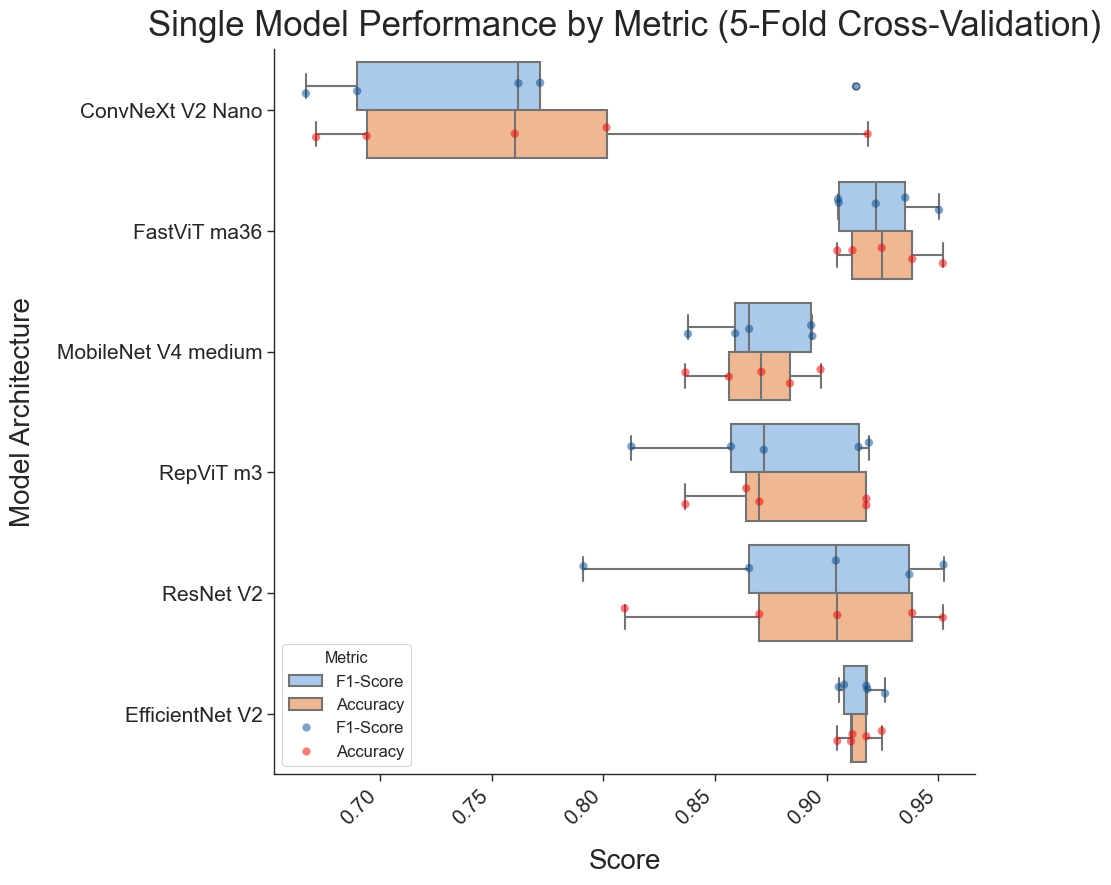

In [43]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# =============================================================================
# 1. SETUP & DATA PREPARATION (Updated for two metrics)
# =============================================================================

# --- Convert to a long-form DataFrame suitable for 'hue' ---
plot_data = []
for model_name, data in allModelMetaData.items():
    if model_name in modelGroupReps:
        commonName = modelGroupRepCommonName[modelGroupReps.index(model_name)]
        for i in range(len(data['f1s'])):
            plot_data.append({'Model Name': commonName, 'Score': data['f1s'][i], 'Metric': 'F1-Score'})
            plot_data.append({'Model Name': commonName, 'Score': data['accs'][i], 'Metric': 'Accuracy'})
# for i in range(len(ensembleModelMetaData['f1s'])):
#     plot_data.append({'Model Name': modelGroupRepCommonName[-1], 'Score': ensembleModelMetaData['f1s'][i], 'Metric': 'F1-Score'})
#     plot_data.append({'Model Name': modelGroupRepCommonName[-1], 'Score': ensembleModelMetaData['accs'][i], 'Metric': 'Accuracy'})
df = pd.DataFrame(plot_data)

# =============================================================================
# 2. PLOTTING (Updated with the 'hue' parameter)
# =============================================================================

sns.set_theme(style="ticks", context="paper", font_scale=1.2)
fig, ax = plt.subplots(figsize=(10, 9)) # Made figure wider

# --- Draw the grouped box plot using the 'hue' parameter ---
sns.boxplot(
    data=df,
    x='Score',
    y='Model Name',
    hue='Metric', # This is the key change!
    ax=ax,
    palette="pastel",
    linewidth=1.5, # Change the box edge line width
    medianprops={'linewidth': 1.5}, # Make the median line thicker
    whiskerprops={'linewidth': 1.5}, # Make whiskers a bit thicker
    capprops={'linewidth': 1.5} # Make caps a bit thicker
)

# --- Overlay individual points (optional but good for detail) ---
sns.stripplot(
    data=df,
    x='Score',
    y='Model Name',
    hue='Metric',
    ax=ax,
    dodge=True, # This separates the points by 'hue'
    palette=['#00468b', '#ed0000'], # Dark color for points
    alpha=0.5,
    jitter=0.15,
    size=6
)

# =============================================================================
# 3. FINAL TOUCHES AND SAVING
# =============================================================================

ax.set_title('Single Model Performance by Metric (5-Fold Cross-Validation)', fontsize=25, pad=10)
ax.set_xlabel('Score', fontsize=20, labelpad=15)
ax.set_ylabel('Model Architecture', fontsize=20, labelpad=15)
# ax.set_ylim(0.6, 1.05)
plt.xticks(rotation=45, ha='right', fontsize=15)
plt.yticks(fontsize=15)
ax.legend(title='Metric', fontsize=12)
sns.despine()
plt.tight_layout()
fig.savefig('model_performance_grouped_boxplot.tiff', dpi=300, bbox_inches='tight')
plt.show()

## PRC and ROC curves for all best models per group and calculate their AUCs as well

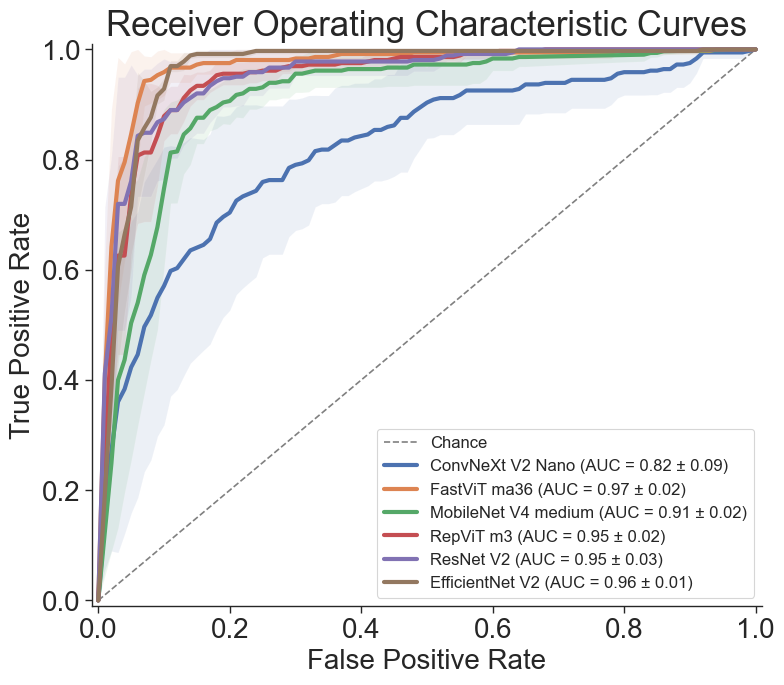

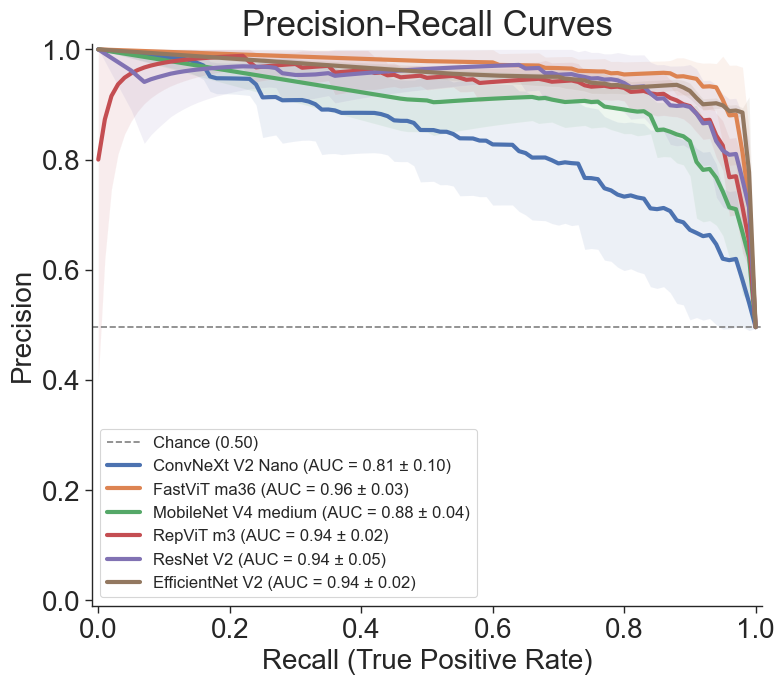

In [33]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score


y_true_all_folds = {i: modelOutputs[model_path][i][0] for i in range(5)}
# =============================================================================
# 2. PLOTTING SCRIPT
# =============================================================================

def plot_curves_with_ci(model_data, true_labels, curve_type='roc'):
    """
    Plots ROC or PRC curves for multiple models with confidence intervals.
    
    Args:
        model_data (dict): Dictionary with model predictions.
        true_labels (dict): Dictionary with true labels for each fold.
        curve_type (str): 'roc' for ROC curves or 'prc' for PRC curves.
    """
    sns.set_theme(style="ticks", context="paper", font_scale=1.2)
    fig, ax = plt.subplots(figsize=(8, 7))

    # Define a common x-axis for interpolation
    if curve_type == 'roc':
        base_x = np.linspace(0, 1, 101)
        ax.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Chance')
    else: # prc
        base_x = np.linspace(0, 1, 101)
        # For PRC, "chance" line depends on class prevalence
        prevalence = np.mean(np.concatenate(list(true_labels.values())))
        ax.axhline(y=prevalence, linestyle='--', color='gray', label=f'Chance ({prevalence:.2f})')
        
    for model_name, fold_data in model_data.items():
        
        interp_y_folds = []
        aucs = []
        
        for i in range(5): # Loop through 5 folds
            y_true = true_labels[i]
            y_pred_proba = fold_data[i]

            if curve_type == 'roc':
                # ROC Curve
                fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
                roc_auc = auc(fpr, tpr)
                aucs.append(roc_auc)
                # Interpolate TPR onto the common FPR base
                interp_y = np.interp(base_x, fpr, tpr)
                interp_y[0] = 0.0 # Ensure it starts at 0
            else:
                # PRC Curve
                precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
                pr_auc = average_precision_score(y_true, y_pred_proba)
                aucs.append(pr_auc)
                # Interpolate Precision onto the common Recall base
                # Note: Recall is x-axis, Precision is y-axis. We reverse them for interpolation.
                interp_y = np.interp(base_x, recall[::-1], precision[::-1])

            interp_y_folds.append(interp_y)

        # Calculate mean and std deviation of the interpolated curves
        mean_y = np.mean(interp_y_folds, axis=0)
        std_y = np.std(interp_y_folds, axis=0)
        
        # Calculate mean AUC
        mean_auc = np.mean(aucs)
        std_auc = np.std(aucs)
        
        # Plot the mean curve
        ax.plot(base_x, mean_y, label=f'{model_name} (AUC = {mean_auc:.2f} ± {std_auc:.2f})', linewidth=3)
        
        # Plot the shaded confidence interval
        y_upper = np.minimum(mean_y + std_y, 1)
        y_lower = np.maximum(mean_y - std_y, 0)
        ax.fill_between(base_x, y_lower, y_upper, alpha=0.1)

    # --- Final Touches ---
    if curve_type == 'roc':
        ax.set_xlabel('False Positive Rate', fontsize=20)
        ax.set_ylabel('True Positive Rate', fontsize=20)
        ax.set_title('Receiver Operating Characteristic Curves', fontsize=25)
        filename = 'roc_curves.tiff'
    else:
        ax.set_xlabel('Recall (True Positive Rate)', fontsize=20)
        ax.set_ylabel('Precision', fontsize=20)
        ax.set_title('Precision-Recall Curves', fontsize=25)
        filename = 'prc_curves.tiff'

    ax.legend(loc='lower right' if curve_type == 'roc' else 'best', fontsize=12)
    ax.tick_params(axis='both', labelsize=20)
    ax.set_xlim([-0.01, 1.01])
    ax.set_ylim([-0.01, 1.01])
    sns.despine()
    plt.tight_layout()
    fig.savefig(filename, dpi=300)
    plt.show()

# =============================================================================
# 3. GENERATE THE PLOTS
# =============================================================================

# --- Generate ROC Plot ---
plot_curves_with_ci(modelPredAllFolds, y_true_all_folds, curve_type='roc')

# --- Generate PRC Plot ---
plot_curves_with_ci(modelPredAllFolds, y_true_all_folds, curve_type='prc')

## Compare all individual models and their respective percent of advantage and disadvantage vs ensemble. This includes ConvNext, which wasn't included in ensemble model; can discuss how we rightfully excluded it in discussion, as it would have contributed little (based on advantage)
### Collect data, info

In [35]:
modelGroupRepCommonName

['FastViT ma36',
 'MobileNet V4 medium',
 'RepViT m3',
 'ResNet V2',
 'EfficientNet V2',
 'ConvNeXt V2 Nano',
 'Ensemble']

In [ ]:
from sklearn.metrics import cohen_kappa_score

def disagreement_rate(y_model, y_ensemble):
    return np.mean(y_model != y_ensemble)

def kappa_with_ensemble(y_model, y_ensemble):
    return cohen_kappa_score(y_model, y_ensemble)

dataFrameData = {}

modelsNames = modelGroupRepCommonName
params_m = np.array([44.1, 11.1, 10.7, 25.5, 21.4, 0.0])  # ensemble param = 0.0 (for clarity). for ['FastViT ma36', 'MobileNet V4 medium', 'RepViT m3', 'ResNet V2', 'EfficientNet V2', 'ConvNeXt V2 Nano', 'Ensemble']
f1_mean = np.array([])
f1_std = np.array([])
acc_mean = np.array([])
acc_std = np.array([])
solo_corrects = np.array([])
unique_errors = np.array([])
disagreement = disagreement_rate(y_model, y_ensemble) #should be equal to solo_corrects+unique_errors
kappa = kappa_with_ensemble(y_model, y_ensemble)


dataFrameData['Parameters (M)'] = params_m
# f1_mean = [0.86, 0.88, 0.85, 0.90, 0.92]
# f1_std = [0.02, 0.01, 0.03, 0.02, 0.01]
# acc_mean = [0.88, 0.89, 0.86, 0.91, 0.93]
# acc_std = [0.02, 0.01, 0.02, 0.01, 0.01]
# solo_corrects = [12, 8, 10, 4, np.nan]  # n samples correct by model but missed by ensemble
# unique_errors = [25, 19, 27, 11, np.nan]  # n samples missed by model but correct by ensemble
# disagreement = [0.074, 0.061, 0.082, 0.041, 0.0]  # fraction disagreeing
# kappa = [0.82, 0.85, 0.80, 0.88, 1.0]

In [ ]:
# Combine into DataFrame
# df = pd.DataFrame({
#     "Model": models,
#     "Params (M)": params_m,
#     "F1 (± SD)": [f"{m:.2f} ± {s:.2f}" for m, s in zip(f1_mean, f1_std)],
#     "Accuracy (± SD)": [f"{m:.2f} ± {s:.2f}" for m, s in zip(acc_mean, acc_std)],
#     "Solo corrects (n)": solo_corrects,
#     "Unique errors (n)": unique_errors,
#     "Disagreement (%)": [f"{100*d:.1f}" for d in disagreement],
#     "κ (ensemble)": [f"{k:.2f}" for k in kappa],
# })

# Display in notebook
print(df)

# Export to LaTeX for JIIM / Springer
latex_table = df.to_latex(index=False, escape=False, column_format="lccccccc", bold_rows=False)

with open("model_comparison_table.tex", "w") as f:
    f.write(latex_table)

print(latex_table)


# Other

In [7]:
# import json

In [9]:
# with open("ensemble_data_new.json", "w") as file:
#     file.write(json.dumps(ensembles, indent=2))

# with open("ensemble_simple_new.json", "w") as file:
#     ensembles_simple = [{ "accuracy": fold["accuracy"], "f-score": fold["f-score"], "ensemble_f1_score": fold["ensemble_f1_score"] }for fold in ensembles]
#     file.write(json.dumps(ensembles_simple, indent=2))